# This is a notebook used to analyze the how nexa is able to proces spikes as discrete signals instead of firing rates.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot inline
%matplotlib inline

# Add the proper path
import sys
sys.path.append("../")

# Local libraries
from signals.aux_functions import gaussian_bump, combine_gaussian_bumps
from signals.spikes import inh_poisson_generator, sparse_to_dense
from scipy.signal import hamming, fftconvolve
from scipy.signal import boxcar
from inputs.sensors import Sensor, PerceptualSpace
from inputs.lag_structure import LagStructure
from inputs.sensors import Sensor, PerceptualSpace
from inputs.lag_structure import LagStructure

# Widgets library
from ipywidgets import interact

## First we generate the bumps and transform them to spikes

In [30]:
Tmax = 1100
dt = 1.0
time = np.arange(0, Tmax, dt)
# We set the random set
np.random.seed(100)

In [31]:
# We define the bump parameters 
max_rate = 100
base = 10
value = 50
attenuation = 2

center1 = 250
distance = 400
center2 = center1 + distance

In [32]:
# Create the gaussian bumpbs
gb1 = gaussian_bump(time, center1, max_rate, base, value, attenuation)
gb2 = gaussian_bump(time, center2, max_rate, base, value, attenuation)

# Add some noise
gb1 += np.random.rand(gb1.size)
gb2 += np.random.rand(gb2.size)

(0, 120)

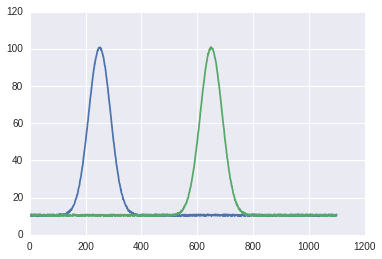

In [33]:
plt.plot(time, gb1)
plt.plot(time, gb2)
plt.ylim([0, max_rate + 20])

## Now we need to get spikes from those rates as an inhomogenous poisson process

In [45]:
# Let's get t_stop
t_stop = Tmax / dt

sparse_spikes1 = inh_poisson_generator(gb1, time, t_stop)
dense_spikes1 = 20 * sparse_to_dense(sparse_spikes1, dt, t_stop)

sparse_spikes2 = inh_poisson_generator(gb2, time, t_stop)
dense_spikes2 = 20 * sparse_to_dense(sparse_spikes2, dt, t_stop)

## Add randonmness to dense spikes
dense_spikes1 += np.random.rand(dense_spikes1.size)
dense_spikes2 += np.random.rand(dense_spikes2.size)

### Let's see how the spikes look like as a sanity check

(0, 120)

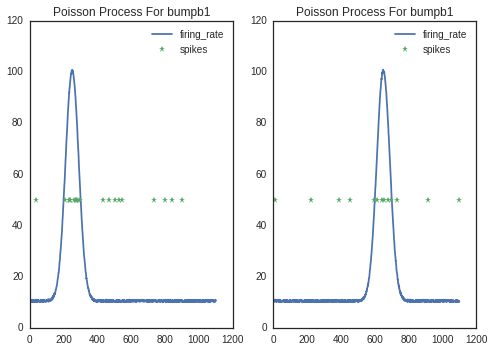

In [46]:
# First plot
plt.subplot(1, 2, 1)
plt.plot(time, gb1, label='firing_rate')
ones = (max_rate / 2) * np.ones_like(sparse_spikes1)
plt.plot(sparse_spikes1, ones, '*', label='spikes')
plt.title('Poisson Process For bumpb1')
plt.legend()
plt.ylim([0,max_rate + 20])

# Second plot
plt.subplot(1, 2, 2)
plt.plot(time, gb2, label='firing_rate')
ones = (max_rate / 2) * np.ones_like(sparse_spikes2)
plt.plot(sparse_spikes2, ones, '*', label='spikes')
plt.title('Poisson Process For bumpb1')
plt.legend()
plt.ylim([0,max_rate + 20])

## Nexa Machinery

In [47]:
# Input structure
from signals.aux_functions import bump
from inputs.sensors import Sensor, PerceptualSpace
from inputs.lag_structure import LagStructure

# Nexa
from nexa.nexa import Nexa

#### Perceptual space

In [48]:
lag_times = np.arange(0, 1000, 200)
window_size = 200
Nwindowsize = int(window_size / dt) 
weights = None
lag_structure = LagStructure(lag_times=lag_times, weights=weights, window_size=window_size)
sensor1 = Sensor(dense_spikes1, dt, lag_structure)
sensor2 = Sensor(dense_spikes2, dt, lag_structure)
sensors = [sensor1, sensor2]
perceptual_space = PerceptualSpace(sensors, lag_first=True)

#### Nexa object

In [49]:
Nspatial_clusters = 2  # Number of spatial clusters
Ntime_clusters = 4  # Number of time clusters
Nembedding = 2  # Dimension of the embedding space

# Now the Nexa object
nexa_object = Nexa(perceptual_space, Nspatial_clusters,
                   Ntime_clusters, Nembedding)

### Visualizations

In [50]:
# Visualization libraries
from visualization.sensor_clustering import visualize_cluster_matrix
from visualization.sensors import visualize_SLM
from visualization.sensors import visualize_STDM_seaborn

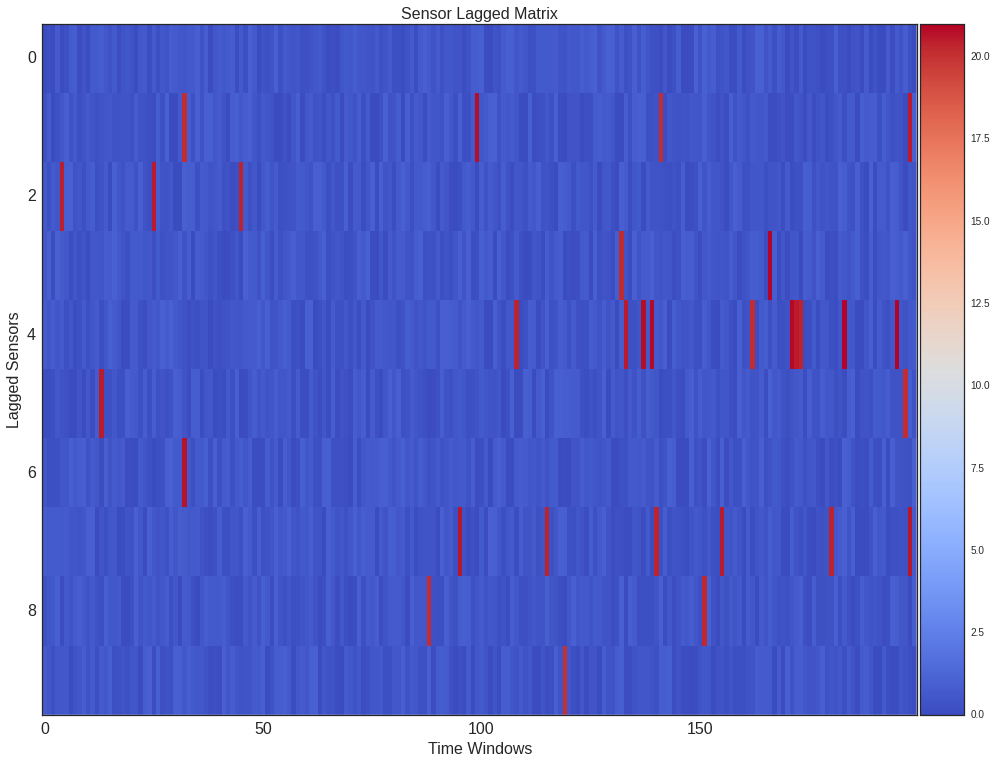

In [51]:
%matplotlib inline
fig = visualize_SLM(nexa_object)
plt.show(fig)

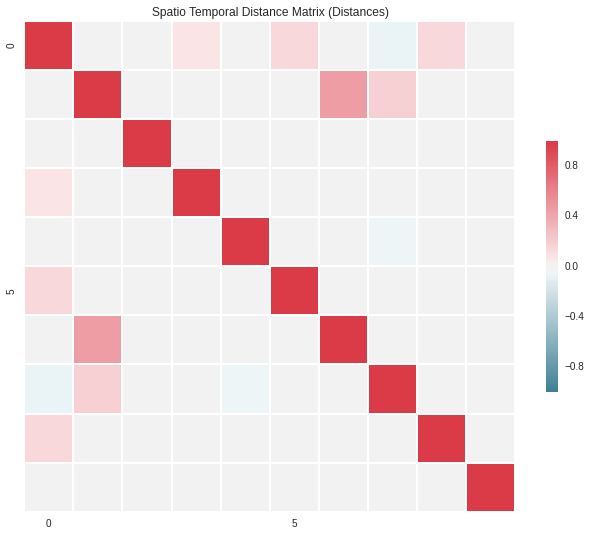

In [52]:
nexa_object.calculate_distance_matrix()
fig = visualize_STDM_seaborn(nexa_object)
plt.show(fig)

In [54]:
nexa_object.Nspatial_clusters = 2
nexa_object.calculate_spatial_clustering(centers=True)
fig = visualize_cluster_matrix(nexa_object)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').